In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

In [ ]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


### 1. Data

In [ ]:
# Create data using the linear regression formula y = weight * X + bias
weight = 0.7
bias = 0.3

# Create X and y (features and labels)
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Testing data')

  # Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # Show the legend
  plt.legend(prop={'size': 14});

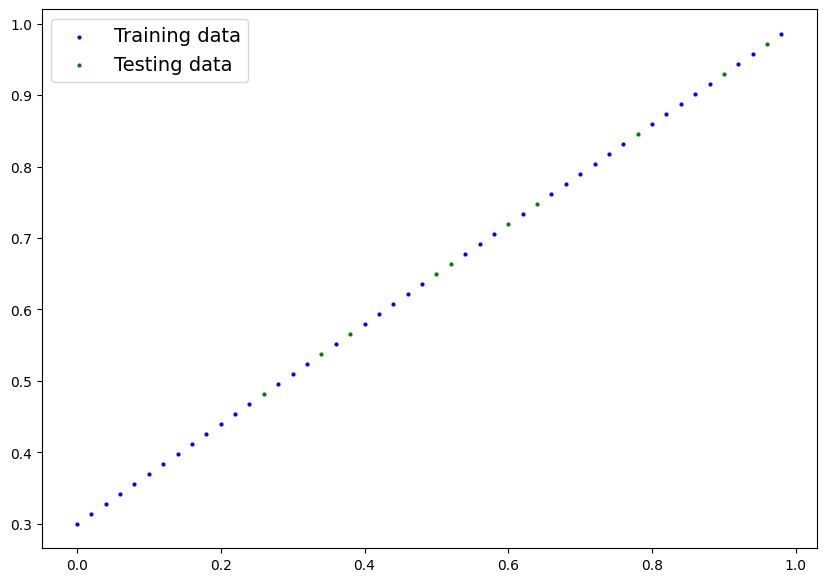

In [ ]:
# Plot the data
plot_predictions(X_train, y_train, X_test, y_test)

## 2. Building a PyTorch Linear model

In [ ]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModel()
model_1, model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [ ]:
X_train[:5], y_train[:5]

(tensor([[0.2400],
         [0.0800],
         [0.7400],
         [0.1600],
         [0.0600]]),
 tensor([[0.4680],
         [0.3560],
         [0.8180],
         [0.4120],
         [0.3420]]))

In [ ]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

### 3. Training

In [ ]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [ ]:
# Training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')

Epoch: 0 | Loss: 0.5600506067276001 | Test loss: 0.5552194714546204
Epoch: 10 | Loss: 0.4383816719055176 | Test loss: 0.42784810066223145
Epoch: 20 | Loss: 0.3167126774787903 | Test loss: 0.3004767596721649
Epoch: 30 | Loss: 0.19504375755786896 | Test loss: 0.17310543358325958
Epoch: 40 | Loss: 0.07337480783462524 | Test loss: 0.04598527029156685
Epoch: 50 | Loss: 0.0360596664249897 | Test loss: 0.024147968739271164
Epoch: 60 | Loss: 0.029995162039995193 | Test loss: 0.020626747980713844
Epoch: 70 | Loss: 0.024409985169768333 | Test loss: 0.01669568382203579
Epoch: 80 | Loss: 0.018832748755812645 | Test loss: 0.012815380468964577
Epoch: 90 | Loss: 0.013247576542198658 | Test loss: 0.008884328417479992
Epoch: 100 | Loss: 0.007668554782867432 | Test loss: 0.005004018545150757
Epoch: 110 | Loss: 0.0020851530134677887 | Test loss: 0.0010729581117630005
Epoch: 120 | Loss: 0.010759826749563217 | Test loss: 0.0016480416525155306
Epoch: 130 | Loss: 0.010759826749563217 | Test loss: 0.001648041

In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7027]])),
             ('linear_layer.bias', tensor([0.3095]))])

In [ ]:
weight, bias

(0.7, 0.3)

### 4. Making and evaluating predictions

In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds

tensor([[0.4922],
        [0.8576],
        [0.7311],
        [0.9419],
        [0.5484],
        [0.9841],
        [0.6749],
        [0.6609],
        [0.7592],
        [0.5765]])

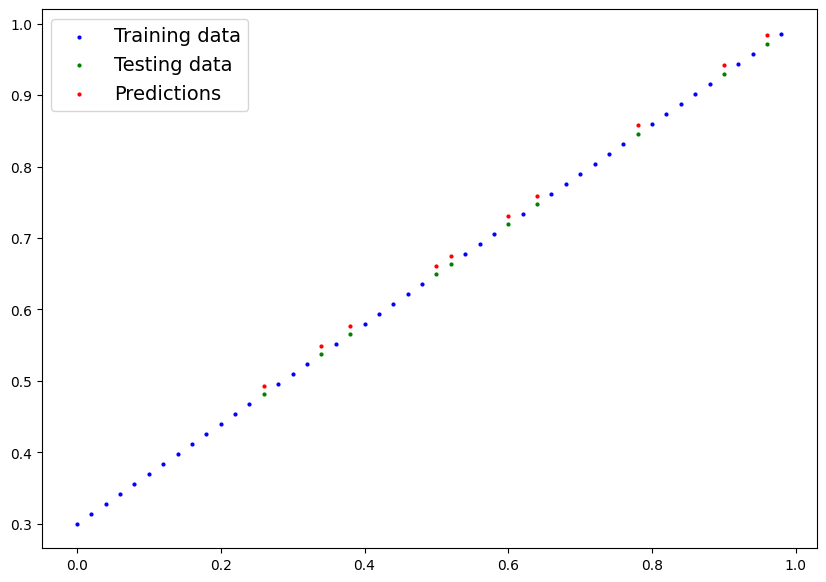

In [ ]:
# Check out our model predictions visually
plot_predictions(predictions=y_preds.cpu())

### Saving & loading a trained model

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_linear_regression_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_linear_regression_model.pth


In [ ]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7027]])),
             ('linear_layer.bias', tensor([0.3095]))])

In [ ]:
# Load a PyTorch model

# Create a new instance of linear regression model
loaded_model_1 = LinearRegressionModel()

# Load the saved model_1 state_dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
next(loaded_model_1.parameters()).device

device(type='cpu')

In [ ]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7027]])),
             ('linear_layer.bias', tensor([0.3095]))])

In [ ]:
# Evaluate the loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])